## Análise da Coleta de Dados

Realiza uma análise dos dados coletados para realização do experimento.

In [1]:
import sqlite3, firebase_admin, json, datetime

import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import seaborn as sns

from firebase_admin import firestore, credentials

## Read cv-node DB

Carrega as imagens e os metadados coletados via cv-node DB (Firebase Firestone) e criar o datasource.

In [2]:
try:
    firebase_admin.initialize_app(credentials.Certificate('../fb-credentials.json'))
    db = firestore.client()
except:
    print('fail')

In [3]:
# Keeping pandas from truncating long strings
pd.set_option('display.max_colwidth', 120)
sns.set_theme(style="ticks", font_scale=1.5)

In [4]:
# Folders constants
data_dir_path = '../data'

source_dir_path = f'{data_dir_path}/source'
work_dir_path   = f'{data_dir_path}/work'

dataset_dir_path  = f'{source_dir_path}/dataset'
supplies_dir_path = f'{source_dir_path}/supplies'
figures_dir_path  = 'output/figures'

In [5]:
cache = True

if not cache:
    project_id = "ALue3cViohd03AlkOc5E"
    base_ref = db.collection(
        "projects"
    ).document(
        project_id
    ).collection(
        "collects"
    )
    
    collects = []
    for c in base_ref.stream():
        data = c.to_dict()
        data['collect_id'] = c.id
        collects.append(data)
    
    things = []
    for c in collects:
        for t in base_ref.document(c['collect_id']).collection("data").stream():
            data = t.to_dict()
            data['collect_id'] = c['collect_id']
            data['thing_id'] = t.id
            things.append(data)
    
    images = []
    for t in things:
        for i in base_ref.document(t['collect_id']).collection("data").document(t['thing_id']).collection("images").stream():
            data = i.to_dict()
            data['thing_id'] = t['thing_id']
            data['image_id'] = i.id
            images.append(data)
    
    df_collects = pd.DataFrame.from_dict(collects)
    print(f'collects: {df_collects.shape}')
    
    df_things = pd.DataFrame.from_dict(things)
    print(f'things: {df_things.shape}')
    
    df_images = pd.DataFrame.from_dict(images)
    print(f'images: {df_images.shape}')
    
    df_collects.to_csv(f'{dataset_dir_path}/collects.csv', index=False)
    df_things.to_csv(f'{dataset_dir_path}/things.csv'    , index=False)
    df_images.to_csv(f'{dataset_dir_path}/images.csv'    , index=False)        
else:
    df_collects = pd.read_csv(f'{dataset_dir_path}/collects.csv')
    print(f'collects: {df_collects.shape}')
    
    df_things = pd.read_csv(f'{dataset_dir_path}/things.csv')
    print(f'things: {df_things.shape}')
    
    df_images = pd.read_csv(f'{dataset_dir_path}/images.csv')
    print(f'images: {df_images.shape}')

collects: (5, 4)
things: (296, 12)
images: (25743, 10)


In [6]:
df_collects.head()

,nodeHeight,place,happenedAt,collect_id
0,190,CTT,1734523691545,OXlA4HTt69EhKln64Cjz
1,190,Divino - Curral 1,1737887457302,UYb4dOtZoiguKcF7SK69
2,190,CTT,1731154590848,dZFVs4MkQa1py9r9Nguj
3,190,Divino - Curral 1,1737802699785,of8VwxX9TG1PMJhhx8kf
4,190,Jarbson,1737828692339,pCxbeJYAIoIqLgEz87pB


In [7]:
dataset_v0 = df_collects.query(
    "collect_id.isin(['UYb4dOtZoiguKcF7SK69', 'of8VwxX9TG1PMJhhx8kf', 'pCxbeJYAIoIqLgEz87pB'])"
).merge(df_things, on='collect_id')
dataset_v0.shape

(262, 15)

## Transformações e Análise I

Realiza transformações na base de dados com o intuíto de remover os registros que não serão utilizados nos experimentos.

### Animais registrados via cv-app

Representa o total de animais cujos pesos e metadados foram coletados via cv-app durante a coleta de dados.

In [8]:
dataset_v0.groupby(['collect_id','tag']).size().reset_index().shape

(260, 3)

### Animais com imagens coletadas 

Remove da base os animais para os quais não foram capturadas imagens, em virtude do problema da câmera no 2° dia de coleta.

In [9]:
dataset_v1 = dataset_v0.merge(
    df_images.query('label.notna()')[['thing_id','image_id','begin_at','final_at','depth','label']], 
    on='thing_id'
)
dataset_v1.groupby(['collect_id','tag']).size().reset_index().shape

(221, 3)

In [10]:
dataset_v1.shape

(16938, 20)

In [11]:
# Dataset com os removidos
dataset_rm_v0 = dataset_v0.query(f'tag not in {dataset_v1['tag'].unique().tolist()}').iloc[:,:]

dataset_rm_v0['reason'] = 'Nenhuma imagem foi coletada ou rotulada como suited'
dataset_rm_v0.shape

(39, 16)

### Remove imagens de animais que apresentaram problemas na coleta

Remove imagens de animais que apresentaram alguma incorformidade durante a coleta das imagens, como Pulo ou falha da tecnologia.

In [12]:
jobs_status = pd.read_csv(f'{supplies_dir_path}/collects_obstaclesx.csv')
jobs_status.columns = ['place', 'job_id', 'status', 'obs']

jobs_status.head(3)

,place,job_id,status,obs
0,Divino - Lote 1,9,Intrusion,O pé de alguém aparece em alguns frames
1,Divino - Lote 1,10,Suited,NaN
2,Divino - Lote 1,11,Suited,NaN


In [13]:
con = sqlite3.connect(f'{supplies_dir_path}/cvnode-acaua.db')
cur = con.cursor()

jobs = pd.read_sql_query(
    "SELECT rowid, * from jobs", 
    con, 
    parse_dates=['begin_at', 'final_at']
)
jobs.shape

(307, 7)

In [14]:
valid_jobs = jobs.merge(
    jobs_status.query("status in ['Suited', 'Intrusion']"), 
    left_on='rowid', 
    right_on='job_id'
).groupby('thing_id').agg({'rowid': lambda x: list(x)}).reset_index()

valid_jobs.columns = ['thing_id', 'jobs']
valid_jobs.shape

(191, 2)

In [15]:
dataset_v2 = dataset_v1.merge(
    valid_jobs, 
    on='thing_id'
)
dataset_v2.groupby(['collect_id','tag']).size().reset_index().shape

(190, 3)

In [16]:
dataset_v2.shape

(14700, 21)

In [17]:
dataset_rm_v1 = pd.concat(
    [dataset_rm_v0, dataset_v1.query(
        f'thing_id not in {dataset_v2['thing_id'].unique().tolist()}'
    ).groupby(
        'thing_id'
    ).first().iloc[:,:]], 
    ignore_index=True
)

dataset_rm_v1['reason'] = dataset_rm_v1.apply(lambda x: 'Job inválido' if pd.isna(x['reason']) else x['reason'], axis=1)
dataset_rm_v1.shape

(70, 21)

Remove as imagens do animal de TAG 0473 porque o peso foi registrado errado ;(

In [18]:
dataset_v3 = dataset_v2.query('tag != "0473"').iloc[:,:]
dataset_v3.shape

(14627, 21)

In [19]:
dataset_v3.groupby(['collect_id','tag']).size().reset_index().shape

(189, 3)

In [20]:
dataset_rm_v2 = pd.concat(
    [dataset_rm_v1, dataset_v2.query('tag == "0473"').groupby('tag').first().iloc[:,:]], 
    ignore_index=True
)

dataset_rm_v2['reason'] = dataset_rm_v2.apply(lambda x: 'Peso inconsistente' if pd.isna(x['reason']) else x['reason'], axis=1)
dataset_rm_v2.shape

(71, 22)

In [21]:
dataset_rm_v2.to_csv('output/dataset_rm.csv', index=False)

### Remove imagens com problemas "pontuais"

Remove imagens de problemas detectados somente com alguns frames durante a coleta, como o caso em que animais invadiram o corredor.

In [22]:
# Imagens do animal de TAG 0014 em que houve invasão de outros 2 animais
runs_of_job_12 = pd.read_sql_query(
    """SELECT r.rowid, i.file_path 
        FROM runs r
        JOIN itens i on i.run_id = r.rowid
        WHERE r.job_id = 12 
          AND r.rowid > 559
          AND i.type = 'DEPTH'""", 
    con,
)
imgs_to_remove = runs_of_job_12['file_path'].to_list()
len(imgs_to_remove)

19

In [23]:
dataset_v4 = dataset_v3.query(f"depth not in {imgs_to_remove}")
dataset_v4.shape

(14608, 21)

## Analysis II

Criar novas colunas para ajudar na análise dos dados e faz um estudo da dispersão da quantidade de imagens por animal.

### Setting birthdate

Complementa a base de dados com a informação de data de nascimento dos animais e calcula a idade dos animais na data de coleta.

In [24]:
# Opening JSON file
birthdates_list = []
for file_path in ['divinox_birthdates.json','jarbson_birthdates.json']:
    with open(f'{supplies_dir_path}/{file_path}') as json_file:
        birthdates_list.extend(json.load(json_file)['results'])

birthdates = pd.DataFrame.from_records(birthdates_list)
birthdates.columns = ['user','tag','birthdate','status']
birthdates.shape

(1170, 4)

In [25]:
dataset_v5 = dataset_v4.merge(birthdates.query('status == 0'), on='tag', how='left')
dataset_v5.shape

(14608, 24)

In [26]:
dataset_v5['birthdate2'] = dataset_v5.apply(
    lambda row: datetime.datetime.fromtimestamp(row['birthdate'] / 1000) if not np.isnan(row['birthdate']) else None, 
    axis=1
)
dataset_v5[['place','tag','weight','birthdate2']].head(3)

,place,tag,weight,birthdate2
0,Divino - Curral 1,0200,42.2,2023-12-14
1,Divino - Curral 1,0200,42.2,2023-12-14
2,Divino - Curral 1,0200,42.2,2023-12-14


In [27]:
dataset_v5['age'] = dataset_v5.apply(
    lambda row: (datetime.datetime.fromtimestamp(row['happenedAt'] / 1000) - datetime.datetime.fromtimestamp(row['birthdate'] / 1000)).days if not np.isnan(row['birthdate']) else None, 
    axis=1
)

### Base de Dados - Final

Após transformações na base de dados, calcula a quantidade de imagens a serem utilizadas nos experimentos.

In [28]:
imgs_stats_v0 = dataset_v5.groupby('collect_id').agg({'tag':['nunique', 'count']}).reset_index()
imgs_stats_v0.columns = ['collect_id', 'things', 'images']
imgs_stats_v0.head(3)

,collect_id,things,images
0,UYb4dOtZoiguKcF7SK69,24,1981
1,of8VwxX9TG1PMJhhx8kf,67,4550
2,pCxbeJYAIoIqLgEz87pB,98,8077


In [29]:
label_stats_v0 = dataset_v5.groupby(['collect_id', 'label']).size().reset_index(name='qtd')
label_stats_v1 = pd.pivot_table(
    label_stats_v0, 
    values='qtd', 
    columns='label', 
    index='collect_id'
).reset_index()

label_stats_v1 = label_stats_v1.rename(columns={0.0:'suited', 1.0:'backgroud', 2.0:'partial', 3.0:'noise'})
label_stats_v1

label,collect_id,suited,backgroud,partial,noise
0,UYb4dOtZoiguKcF7SK69,173.0,1304.0,354.0,150.0
1,of8VwxX9TG1PMJhhx8kf,381.0,3079.0,682.0,408.0
2,pCxbeJYAIoIqLgEz87pB,1218.0,4967.0,1577.0,315.0


In [30]:
imgs_stats_v2 = imgs_stats_v0.merge(label_stats_v1, on='collect_id')
imgs_stats_v2.head()

,collect_id,things,images,suited,backgroud,partial,noise
0,UYb4dOtZoiguKcF7SK69,24,1981,173.0,1304.0,354.0,150.0
1,of8VwxX9TG1PMJhhx8kf,67,4550,381.0,3079.0,682.0,408.0
2,pCxbeJYAIoIqLgEz87pB,98,8077,1218.0,4967.0,1577.0,315.0


In [31]:
imgs_stats_v2.drop(columns=['collect_id']).sum()

things         189.0
images       14608.0
suited        1772.0
backgroud     9350.0
partial       2613.0
noise          873.0
dtype: float64

## Análise III

Análise somente das imagens Suited.

### Distribuição de Imagens por Animal

In [32]:
suited_imgs_v0 = dataset_v5.query('label == 0.0')
suited_imgs_v0.shape

(1772, 25)

In [33]:
suited_imgs_by_tag = suited_imgs_v0.groupby(['collect_id','tag']).size().reset_index(name='qtd')
suited_imgs_by_tag.sort_values(by='qtd', ascending=False).shape

(189, 3)

In [34]:
q_stats = suited_imgs_by_tag.describe()
q_stats.loc['cv','qtd'] = q_stats.loc['std','qtd'] / q_stats.loc['mean','qtd'] * 100
q_stats

,qtd
count,189.000000
mean,9.375661
std,12.689485
min,2.000000
25%,4.000000
50%,5.000000
75%,9.000000
max,116.000000
cv,135.344955


In [35]:
suited_imgs_by_tag['number of images'] = suited_imgs_by_tag['qtd']

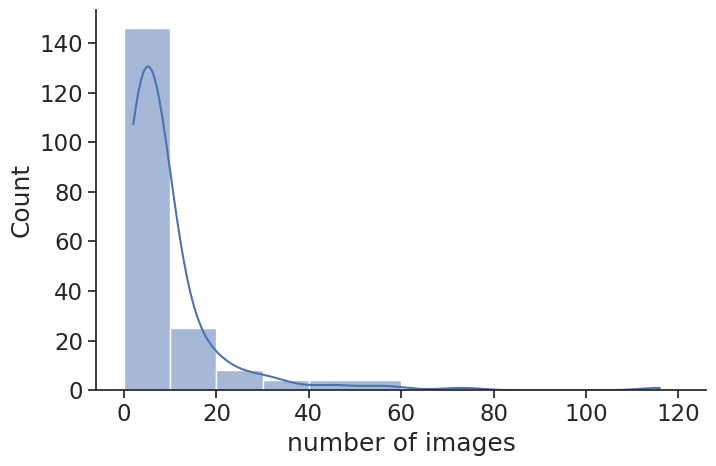

In [37]:
# Plot the orbital period with horizontal boxes
q_distplot = sns.displot(
    suited_imgs_by_tag, 
    x="number of images",
    bins=[0,10,20,30,40,60,80,120],
    aspect=1.5,
    kde=True,
)

q_distplot.savefig(f'{figures_dir_path}/dataset-charts/q_distplot.png', dpi=600)

### Distribuição de Imagens por Peso

In [38]:
a_stats = suited_imgs_v0[['weight']].describe()
a_stats.loc['cv','weight'] = a_stats.loc['std','weight'] / a_stats.loc['mean','weight'] * 100
a_stats

,weight
count,1772.000000
mean,26.288200
std,14.153366
min,4.250000
25%,13.900000
50%,19.850000
75%,40.040000
max,83.650000
cv,53.839238


/tmp/ipykernel_210550/772891271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suited_imgs_v0[['Weight (kg)']] = suited_imgs_v0[['weight']]


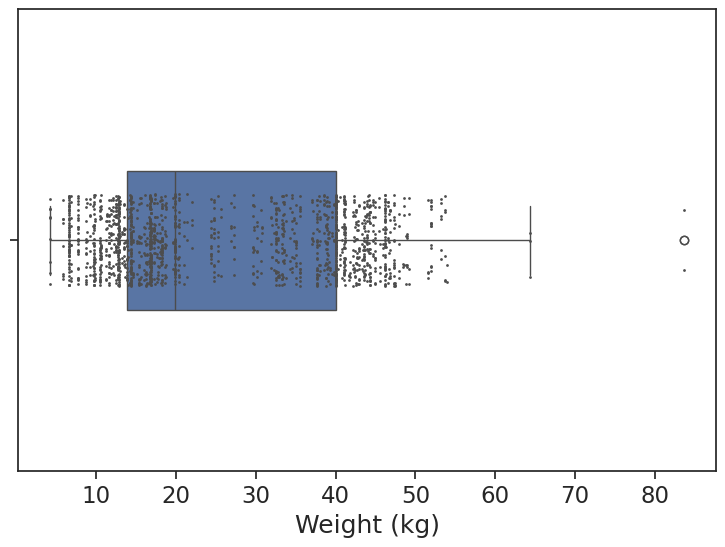

In [40]:
suited_imgs_v0[['Weight (kg)']] = suited_imgs_v0[['weight']]

# Initialize the figure
plt.rcParams['font.size'] = 16
f, ax = plt.subplots(figsize=(9, 6))

# Plot the orbital period with horizontal boxes
w_boxplot = sns.boxplot(
    suited_imgs_v0, 
    x="Weight (kg)",
    orient='x',
    width=.3, 
    # palette="vlag"
)

# Add in points to show each observation
w_stripplot = sns.stripplot(
    suited_imgs_v0,
    x="Weight (kg)", 
    size=2, 
    color=".3"
)

w_boxplot.get_figure().savefig(f'{figures_dir_path}/dataset-charts/w_boxplot.png', dpi=600)

### Distribuição por Idade

In [60]:
w_stats = suited_imgs_v0[['age']].describe()
w_stats.loc['cv','age'] = w_stats.loc['std','age'] / w_stats.loc['mean','age'] * 100
w_stats

,age
count,1772.000000
mean,485.801354
std,612.807757
min,2.000000
25%,59.000000
50%,76.000000
75%,657.000000
max,2460.000000
cv,126.143691


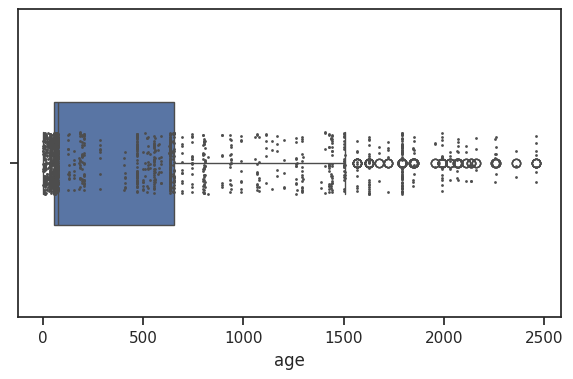

In [61]:
# Initialize the figure
f, ax = plt.subplots(figsize=(7, 4))

# Plot the orbital period with horizontal boxes
a_boxplot = sns.boxplot(
    suited_imgs_v0, 
    x="age",
    orient='x',
    width=.4, 
    # palette="vlag"
)

# Add in points to show each observation
a_stripplot = sns.stripplot(
    suited_imgs_v0, 
    x="age", 
    size=2, 
    color=".3"
)

a_boxplot.get_figure().savefig(f'{figures_dir_path}/a_boxplot.png')

### Relação Idade x Peso

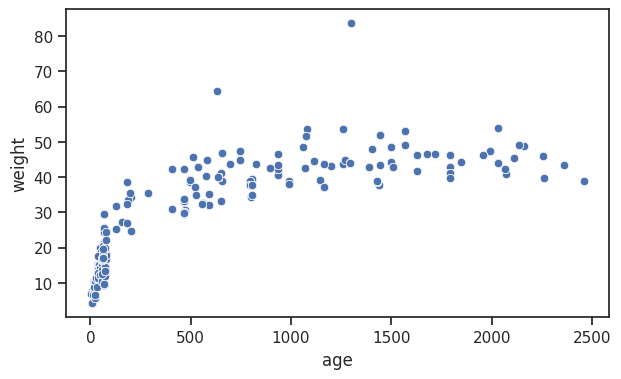

In [62]:
# Initialize the figure
f, ax = plt.subplots(figsize=(7, 4))

a_x_w_scatterplot = sns.scatterplot(data=suited_imgs_v0, x="age", y="weight")
a_x_w_scatterplot.get_figure().savefig(f'{figures_dir_path}/a_x_w_scatterplot.png')

In [63]:
suited_imgs_v0.groupby(
    ['place','collect_id','tag','thing_id','age','weight']
).size().reset_index().sort_values(
    by=['weight','age'], ascending=False
).to_csv(
    'data/age-weight.csv',
    index=False
)

### Distribuição por Sexo

In [64]:
g_stats = suited_imgs_v0.groupby('gender').size().reset_index(name='qtd')
g_stats['perc'] = g_stats['qtd'] / suited_imgs_v0.shape[0] * 100
g_stats

,gender,qtd,perc
0,0,396,22.34763
1,1,1376,77.65237


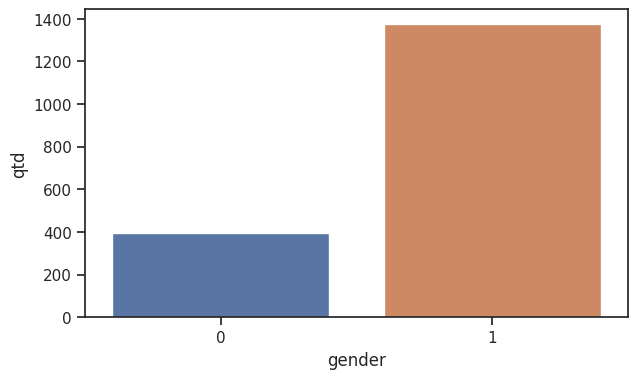

In [65]:
# Initialize the figure
f, ax = plt.subplots(figsize=(7, 4))

g_barplot = sns.barplot(
    g_stats, 
    x="gender", 
    y="qtd", 
    hue="gender", 
    # linewidth=.5,
    legend=False
)

g_barplot.get_figure().savefig(f'{figures_dir_path}/g_barplot.png')

### Distribuição por Nível de Lã

In [66]:
l_stats = suited_imgs_v0.groupby('woolLevel').size().reset_index(name='qtd')
l_stats['perc'] = l_stats['qtd'] / suited_imgs_v0.shape[0] * 100
l_stats

,woolLevel,qtd,perc
0,0.0,1151,64.954853
1,1.0,264,14.898420
2,2.0,340,19.187359


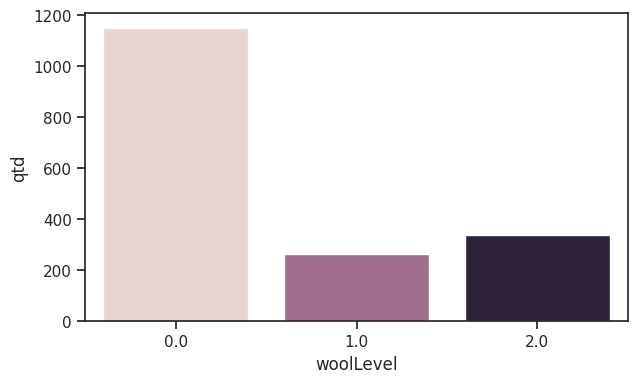

In [67]:
# Initialize the figure
f, ax = plt.subplots(figsize=(7, 4))

l_barplot = sns.barplot(
    l_stats, 
    x="woolLevel", 
    y="qtd", 
    hue="woolLevel", 
    # linewidth=.5,
    legend=False
)

l_barplot.get_figure().savefig(f'{figures_dir_path}/l_barplot.png')

### Distribuição por Escore

In [68]:
s_stats = suited_imgs_v0.groupby('score').size().reset_index(name='qtd')
s_stats['perc'] = s_stats['qtd'] / suited_imgs_v0.shape[0] * 100
s_stats

,score,qtd,perc
0,1.0,7,0.395034
1,2.0,434,24.492099
2,3.0,304,17.155756
3,4.0,78,4.401806
4,5.0,935,52.765237


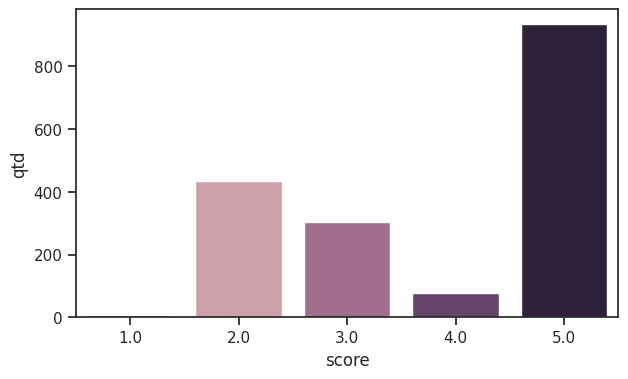

In [69]:
# Initialize the figure
f, ax = plt.subplots(figsize=(7, 4))

s_barplot = sns.barplot(
    s_stats, 
    x="score", 
    y="qtd", 
    hue="score", 
    # linewidth=.5,
    legend=False
)

s_barplot.get_figure().savefig(f'{figures_dir_path}/s_barplot.png')

In [70]:
temp = suited_imgs_v0[['tag','weight','age','gender']].query(
    'age.notna()'
).rename(
    columns={'weight':'y'}
)

temp['x'] = temp['age'].apply(lambda x: int(x))
temp.groupby(['tag','x','y','gender']).size().reset_index(name='qtd').to_csv(
    'output/fit.csv', 
    index=False
)

tag        object
y         float64
age         int64
gender      int64
x           int64
dtype: object
